# 1D Helmholtz Kaczmarz Relaxation Smoothing Factor

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi

In [207]:
t = np.linspace(-pi, pi, 1000)

def gs_relaxation_symbol(a, t):
    """a must be odd, centered at len(a) // 2."""
    mid = len(a) // 2
    left = np.poly1d(a.c[:mid + 1])
    right = np.poly1d(np.concatenate((a.c[mid + 1:][::-1], [0])))
    r = np.abs(right(np.exp(1j * t)) / left(np.exp(-1j * t)))
    return r

def symbols(k, discretization="3-point"):
    if discretization == "3-point":
        a = np.array([1, -2 + k ** 2, 1])
    elif discretization == "5-point":
        a = np.array([-1, 16, -30 + 12 * k ** 2, 16, -1])
    else:
        raise Exception("Unsupported discretization type")
    a = np.poly1d(a)
    a2 = np.polymul(a, a)
    at = np.real(np.exp(-1j * t * (len(a) // 2)) * a(np.exp(1j * t)))
    gs = gs_relaxation_symbol(a, t)
    kac = gs_relaxation_symbol(a2, t)
    return at, gs, kac

def smoothing_factor(at, relax, rho, kind="traditional"):
    if kind == "traditional":
        hf = np.abs(t) >= rho * pi
    elif kind == "svd":
        hf = np.argsort(np.abs(at))[len(t) // 2:]
    else:
        raise Exception("Unsupported smoothing factor type")
    return max(relax[hf])

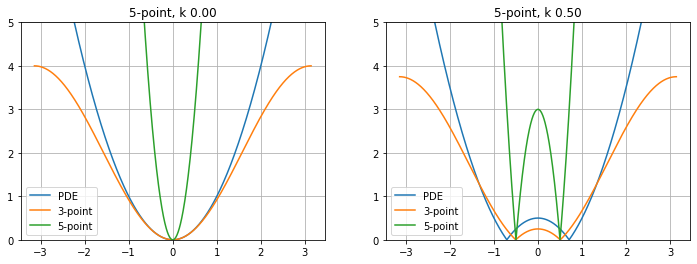

In [233]:
k_values = [0, 0.5]
discretizations = ("3-point", "5-point")
fig, axs = plt.subplots(1, len(k_values), figsize=(6 * len(k_values), 4))
for j, k in enumerate(k_values):
    ax = axs[j]
    ax.plot(t, np.abs(-t ** 2 + k), label="PDE")
    for i, discretization in enumerate(discretizations):
        at = symbols(k, discretization=discretization)[0]
        ax.plot(t, np.abs(at), label=discretization)
    ax.grid(True)
    ax.set_title("{}, k {:.2f}".format(discretization, k))
    ax.set_ylim([0, 5])
    ax.legend();

0.3333333333333333 0.4545454545454546
0.36363636363636365 0.47058823529411764
0.36170212765957444 0.48675136116152445
0.38636363636363635 0.4991941982272361


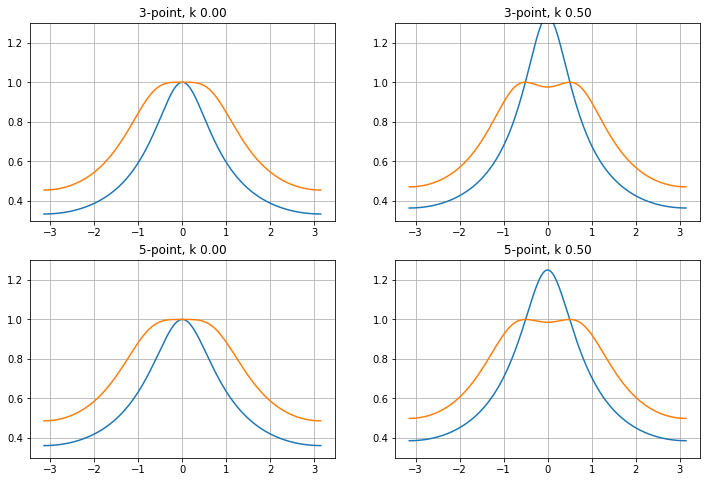

In [240]:
k_values = [0, 0.5]
discretizations = ("3-point", "5-point")
fig, axs = plt.subplots(len(discretizations), len(k_values), 
                        figsize=(6 * len(k_values), 4 * len(discretizations)))
for i, discretization in enumerate(discretizations):
    for j, k in enumerate(k_values):
        at, gs, kac = symbols(k, discretization=discretization)
        ax = axs[i, j]
        ax.plot(t, gs)
        ax.plot(t, kac)
        print(gs[0], kac[0])
        ax.grid(True)
        ax.set_title("{}, k {:.2f}".format(discretization, k))
        ax.set_ylim([0.3, 1.3])

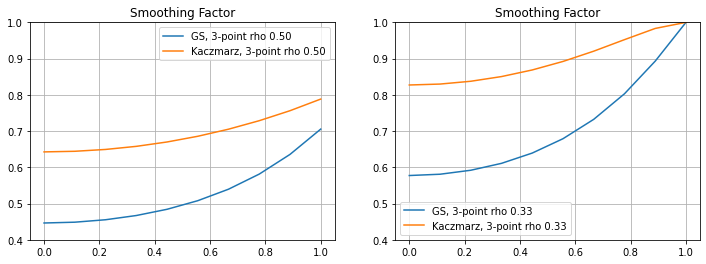

In [270]:
discretizations = ("3-point", )# "5-point")
rho_values = [0.5, 1/3]
k_values = np.linspace(0, 1, num=10)
nk = len(k_values)
nr = len(rho_values)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, discretization in enumerate(discretizations):
    mu_gs = np.zeros((nk, nr))
    mu_kac = np.zeros((nk, nr))
    bmu1_gs = np.zeros((nk, nr))
    bmu1_kac = np.zeros((nk, nr))
    bmu2_gs = np.zeros((nk, nr))
    bmu2_kac = np.zeros((nk, nr))

    for j, k in enumerate(k_values):
        at, gs, kac = symbols(k, discretization=discretization)
        mu_gs[j] = max(abs(gs))
        mu_kac[j] = max(abs(kac))
        for r, rho in enumerate(rho_values):
            bmu1_gs[j, r] = smoothing_factor(at, gs, rho)
            bmu1_kac[j, r] = smoothing_factor(at, kac, rho)
            bmu2_gs[j, r] = smoothing_factor(at, gs, rho, kind="svd")
            bmu2_kac[j, r] = smoothing_factor(at, kac, rho, kind="svd")

    for r, rho in enumerate(rho_values):
        ax = axs[r]
        ax.plot(k_values, bmu1_gs[:, r], label="GS, {} rho {:.2f}".format(discretization, rho))
        ax.plot(k_values, bmu1_kac[:, r], label="Kaczmarz, {} rho {:.2f}".format(discretization, rho))
        ax.grid(True)
        ax.set_title("Smoothing Factor");
        ax.legend() # loc="lower right");
        ax.set_ylim([0.4, 1])

#     ax = axs[1]
#     ax.plot(k_values, mu_gs, label="GS, {}".format(discretization))
#     ax.plot(k_values, mu_kac, label="Kaczmarz, {}".format(discretization))
#     ax.grid(True)
#     ax.set_title("Convergence Factor");
#     ax.set_ylim([0.9, 1.2])
#     ax.legend();